In [1]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

symbol = 'amzn'
epochs = 10
num_neurons = 100
seq_len = 20
pred_len = 1
shift_pred = False

S:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_data(filename, seq_len, pred_len, shift_pred):
    f = open(filename, 'r').read()
    data = f.split('\n')[:-1] # get rid of the last '' so float(n) works
    data.reverse()
    d = [float(n) for n in data]
    lower = np.min(d)
    upper = np.max(d)
    scale = upper-lower
    normalized_d = [(x-lower)/scale for x in d]

    result = []
    if shift_pred:
        pred_len = 1
    for i in range((len(normalized_d) - seq_len - pred_len)//pred_len):
        result.append(normalized_d[i*pred_len: i*pred_len + seq_len + pred_len])
    
    result = np.array(result)
    row = int(round(0.9 * result.shape[0]))
    train = result[:row, :] 
    test = result[row:, :]

    np.random.shuffle(train) 

    X_train = train[:, :-pred_len]
    X_test = test[:, :-pred_len]

    if shift_pred:
        y_train = train[:, 1:] 
        y_test = test[:, 1:]
    else:
        y_train = train[:, -pred_len:]
        y_test = test[:, -pred_len:]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 
                                                                    1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 

    return [X_train, y_train, X_test, y_test, lower, scale]


In [3]:
X_train, y_train, X_test, y_test, lower, scale = load_data(symbol + '.txt', seq_len, pred_len, shift_pred)

In [4]:
model = Sequential()
model.add(Bidirectional(LSTM(num_neurons, return_sequences=True, input_shape=(None, 1)), input_shape=(seq_len, 1)))
model.add(Dropout(0.2))

model.add(LSTM(num_neurons, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(num_neurons, return_sequences=False))
model.add(Dropout(0.2))

if shift_pred:
    model.add(Dense(units=seq_len))
else:
    model.add(Dense(units=pred_len))

model.add(Activation('linear'))
model.compile(loss='mse', optimizer='rmsprop')

model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.05)

print(model.output.op.name)
print(model.input.op.name)

Train on 3947 samples, validate on 208 samples
Epoch 1/10
3947/3947 [==============================] - 3s 859us/step - loss: 0.0053 - val_loss: 2.8227e-04
Epoch 2/10
3947/3947 [==============================] - 2s 479us/step - loss: 0.0010 - val_loss: 7.5835e-05
Epoch 3/10
3947/3947 [==============================] - 5s 1ms/step - loss: 8.0735e-04 - val_loss: 2.4578e-04
Epoch 4/10
3947/3947 [==============================] - 2s 474us/step - loss: 7.4207e-04 - val_loss: 2.2062e-04
Epoch 5/10
3947/3947 [==============================] - 2s 476us/step - loss: 7.6661e-04 - val_loss: 1.8488e-04
Epoch 6/10
3947/3947 [==============================] - 2s 461us/step - loss: 5.1332e-04 - val_loss: 2.9038e-04
Epoch 7/10
3947/3947 [==============================] - 2s 466us/step - loss: 7.9969e-04 - val_loss: 4.2690e-04
Epoch 8/10
3947/3947 [==============================] - 2s 465us/step - loss: 6.8570e-04 - val_loss: 3.6721e-04
Epoch 9/10
3947/3947 [==============================] - 2s 499us/st

In [5]:
saver = tf.train.Saver()
saver.save(K.get_session(), '/tmp/keras_' + symbol + '.ckpt')

predictions = []
correct = 0
total = pred_len*len(X_test)
for i in range(len(X_test)):
    input = X_test[i]
    y_pred = model.predict(input.reshape(1, seq_len, 1))
    predictions.append(scale * y_pred[0][-1] + lower)
    if shift_pred:
        if y_test[i][-1] >= input[-1][0] and y_pred[0][-1] >= input[-1][0]:
            correct += 1
        elif y_test[i][-1] < input[-1][0] and y_pred[0][-1] < input[-1][0]:
            correct += 1
    else:
        for j in range(len(y_test[i])):
            if y_test[i][j] >= input[-1][0] and y_pred[0][j] >= input[-1][0]:
                correct += 1
            elif y_test[i][j] < input[-1][0] and y_pred[0][j] < input[-1][0]:
                correct += 1


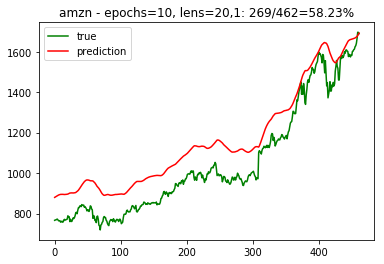

In [6]:
y_test = scale * y_test + lower 
y_test = y_test[:, -1]
xs = [i for i, _ in enumerate(y_test)]
plt.plot(xs, y_test, 'g-', label='true')
plt.plot(xs, predictions, 'r-', label='prediction')
plt.legend(loc=0)
if shift_pred:
    plt.title("%s - epochs=%d, shift_pred=True, seq_len=%d: %d/%d=%.2f%%" %(symbol, epochs, seq_len, correct, total, 100*float(correct)/total))
else:
    plt.title("%s - epochs=%d, lens=%d,%d: %d/%d=%.2f%%" %(symbol, epochs, seq_len, pred_len, correct, total, 100*float(correct)/total))
plt.show()